In [1]:
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

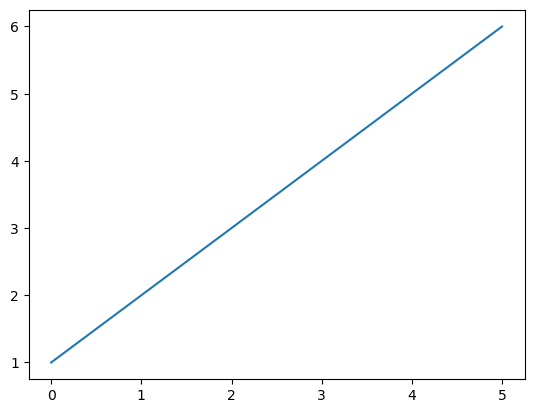

In [3]:
plt.plot([1,2,3,4,5,6])

In [4]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [5]:
import re 
import numpy as np
import pandas as pd
import string

from pathlib import Path
import unicodedata

In [6]:
import torchtext.data 
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors
from torchtext.transforms import ToTensor


In [7]:
path = Path(r'C:/Users/niels/OneDrive/Probabilistic Programming 2022/data/datasets/giga_fren/giga-fren')

In [8]:
class Vocab:
    def __init__(self, name):
        self.name = name
        self.stoi = {}
        self.word2count = {}
        self.itos = {0: "<bos>",1: "<pad>", 2:'<eos>',3:'<unk>'}
        self.n_words = 4

    def add_sentence(self, sentence):
        for w in sentence.split(' '):
            self.add_word(w)

    def add_word(self, w):
        if w not in self.stoi:
            self.itos[self.n_words] = w
            self.stoi = {w:i for (i,w) in self.itos.items()}
            self.word2count[w] = 1 
            self.n_words += 1
        else:
            self.word2count[w] += 1

In [9]:
df = pd.read_csv(path/'questions_easy.csv')

In [10]:
df = df.loc[df['en'].apply(lambda x: len(x.split(' '))<=15) & df['fr'].apply(lambda x: len(x.split(' '))<=15)]

In [11]:
en_vocab = Vocab('en')
fr_vocab = Vocab('fr')

In [12]:
for sent in df['en'].values:
    en_vocab.add_sentence(sent)
    
for sent in df['fr'].values:
    fr_vocab.add_sentence(sent)

In [17]:
df.tail()

,en,fr
52318,where does all the fertilizer go ?,disponible en anglais seulement ou va tout l e...
52319,what happened to the winter issue ?,qu est il advenu du numero de l hiver ?
52323,what about languages other than the national l...,qu en est il des langues autres que la langue ...
52326,what are the mechanisms for increasing women s...,quels sont les mecanismes susceptibles d ameli...
52330,what s inside introduction to sti did you know ?,contenu introduction aux its saviez vous que ?


In [18]:
sentence = 'we are not sure'
en_vocab.add_sentence(sentence)
[en_vocab.stoi[s] for s in sentence.split(' ')]

[10, 9, 110, 733]

In [19]:
''.join([(en_vocab.itos[i] + ' ') for i in [10, 9, 110, 733]])

'we are not sure '

In [20]:
vects_fr = Vectors(r'./.vector_cache/wiki.fr.vec')
vects_en = Vectors(r'./.vector_cache/wiki.en.vec')

In [21]:
en_emb = nn.Embedding(len(en_vocab.stoi),300,padding_idx = 1)
wgts = en_emb.weight.data

In [22]:
miss = []
for w,i in en_vocab.stoi.items():
    try: wgts[i+3] = torch.tensor(vects_en.get_vecs_by_tokens(w))
    except: miss.append(w)

C:\Users\niels\AppData\Local\Temp\ipykernel_39264\1004712414.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  try: wgts[i+3] = torch.tensor(vects_en.get_vecs_by_tokens(w))


In [23]:
fr_emb = nn.Embedding(len(fr_vocab.stoi),300,padding_idx=1).cuda()
wgts = fr_emb.weight.data

In [24]:
miss = []
for w,i in fr_vocab.stoi.items():
    try:wgts[i+1] = torch.tensor(vects_fr.get_vecs_by_tokens(w))
    except: miss.append(w)

C:\Users\niels\AppData\Local\Temp\ipykernel_39264\1072943635.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  try:wgts[i+1] = torch.tensor(vects_fr.get_vecs_by_tokens(w))


In [25]:
en_tokenizer = get_tokenizer(None, language='en')
fr_tokenizer = get_tokenizer(None, language='fr')

In [26]:
inputs = [[en_vocab.stoi[y] for y in en_tokenizer(x)] for x in df['en'].values]
outputs = [[fr_vocab.stoi[y] for y in en_tokenizer(x)] for x in df['fr'].values]

In [27]:
inputs = [[en_vocab.stoi[y] for y in en_tokenizer(x)] for x in df['en'].values]
outputs = [[fr_vocab.stoi[y] for y in en_tokenizer(x)] for x in df['fr'].values]

In [75]:
inputs_tensor = ToTensor(padding_value = 1)(inputs)
outputs_tensor = ToTensor(padding_value = 1)(outputs)

In [76]:
inputs_tensor

tensor([[   4,    5,    6,  ...,    1,    1,    1],
        [   8,    9,   10,  ...,    1,    1,    1],
        [  11,   12,   10,  ...,    1,    1,    1],
        ...,
        [   4,  226, 1696,  ...,    1,    1,    1],
        [   4,    9,   19,  ...,    1,    1,    1],
        [   4,   70, 5994,  ...,    1,    1,    1]])

In [31]:
with torch.no_grad():
    for i in range(4):
        fr_emb.weight[i] = i * torch.ones(300) 
        en_emb.weight[i] = i * torch.ones(300) 

In [32]:
ds = TensorDataset(inputs_tensor.cuda(),outputs_tensor.cuda())

In [33]:
class Encoder(nn.Module):
    def __init__(self,vocab,embed,hidden_size=300,n_layers=2,bidirectional=True,
                dropout=0.5):
        super().__init__()
        self.vocab = vocab
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embed = embed
        self.emb_sz = self.embed.embedding_dim
        self.gru = nn.GRU(self.emb_sz,hidden_size,num_layers=n_layers,bidirectional = True,dropout=0.25,batch_first=True)
        
    def forward(self,src,hidden=None):
        bs = src.size(0)
        
        hidden = torch.zeros(2*self.n_layers,bs,self.hidden_size).cuda()
        
        emb = self.embed(src)
        
        out,h = self.gru(emb,hidden)

        return out,h

In [34]:
class Decoder(nn.Module):
    def __init__(self,vocab,embed,hidden_sz=300,n_layers=2,
                dropout=0.5):
        super().__init__()
        self.vocab = vocab
        self.vocab_sz = len(self.vocab.itos)
        self.hidden_sz = hidden_sz
        self.embed = embed
        self.emb_sz = self.embed.embedding_dim
        self.gru = nn.GRU(2*self.emb_sz + self.hidden_sz,self.hidden_sz,num_layers = n_layers,
                          dropout=0.35,batch_first=True)

        self.dec_to_word = nn.Linear(self.emb_sz,len(vocab.stoi))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self,dec_inp,dec_hid):

        outp, h = self.gru(dec_inp,dec_hid)
        outp = self.dec_to_word(self.dropout(outp))
        return outp, h

In [35]:
class Attention(nn.Module):
    
    def __init__(self,enc,dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
        
        self.enc_emb_sz = enc.embed.embedding_dim
        self.dec_emb_sz = dec.embed.embedding_dim
        
        
        self.enc_att = nn.Linear(2 * enc.hidden_size,self.dec.emb_sz,bias=False)
        self.dec_att = nn.Linear(self.dec_emb_sz,self.dec_emb_sz).cuda()
        
        self.V = nn.Parameter(torch.rand(self.enc.embed.embedding_dim,1))
        
    def forward(self,src,dec_out,dec_hid):
        
        enc_out,enc_hid = self.enc(src)
        
        enc_attn = self.enc_att(enc_out)
        
        u = nn.Tanh()(self.dec_att(dec_hid[-1]).unsqueeze(1) + enc_attn)
        
        attn_wgts = nn.Softmax(dim=1)(u@self.V)
  
        ctx = torch.bmm(attn_wgts.permute(0,2,1),enc_out)
    

        return torch.cat([ctx,self.dec.embed(dec_out)],dim=2)   


In [36]:
class Seq2Seq_Attn(nn.Module):
    def __init__(self,enc,dec):
        super().__init__()
        self.encoder = enc
        self.decoder = dec
        
        self.attn = Attention(self.encoder,self.decoder)
        
        self.enc_emb_dim = 300
        self.dec_emb_dim = 300
        
        self.enc_hid_to_dec_hid = nn.Linear(2*self.enc_emb_dim,self.dec_emb_dim)
        
     
    def forward(self,src):
        bs = src.size(0)
        max_len = 15
        
       
        vocab_size = self.decoder.vocab_sz 
        enc_out,enc_hid = self.encoder(src)
        enc_hid = enc_hid.reshape(2,2,bs,self.enc_emb_dim).permute(1,2,0,3).contiguous()
        enc_hid = enc_hid.reshape(2,bs,2*self.enc_emb_dim) 
        
        dec_hid = self.enc_hid_to_dec_hid(enc_hid.cuda())  
        dec_in = (torch.zeros(src.size(0),1,dtype=torch.long) + torch.LongTensor([[fr_vocab.stoi['<bos>']]])).cuda()
        dec_inp = self.attn(src,dec_in,dec_hid)

        outputs = []

        for t in range(max_len):
            
            outp,dec_hid = self.decoder(dec_inp,dec_hid)

            dec_out = outp.argmax(dim=2)
            
            outputs.append(outp)
            
            dec_inp = self.attn(src,dec_out,dec_hid)
        
        outputs = torch.stack(outputs)

        return outputs

In [37]:
enc = Encoder(en_vocab,en_emb)
dec = Decoder(fr_vocab,fr_emb)

In [38]:
attn = Attention(enc,dec)

In [39]:
dl = DataLoader(ds,batch_size=64,shuffle=True)

In [40]:
def loss_fn(out,tgt):

    return torch.stack([nn.CrossEntropyLoss()(out[i].squeeze(1),tgt.transpose(0,1)[i]) for i in range(tgt.size(1))]).mean()

In [41]:
from torch.optim import Adam

In [42]:
model = Seq2Seq_Attn(enc,dec).cuda()

In [43]:
optim = Adam(model.parameters(),lr=0.001)

In [44]:
import time

In [70]:
%%time
epochs = range(10)
epoch_losses = []
for e in epochs:
    losses = []
    for i, (src,tgt) in enumerate(dl):
        
        out = model(src)
        
        loss = loss_fn(out,tgt)
        
        optim.zero_grad()
        
        loss.backward()
        
        optim.step()
        
        losses.append(loss.item())
        
    epoch_loss = np.mean(losses)    
    epoch_losses.append(epoch_loss)
    print(epoch_loss)
        

1.0551895264855877
1.0603499681411865
1.038752650905274
1.0384748907622225
1.0399987178886245
1.0374937051546549
1.0333543749388583
1.028287550289474
1.0216318931646213
1.0230806465158444
CPU times: total: 39min 16s
Wall time: 1h 17min 35s


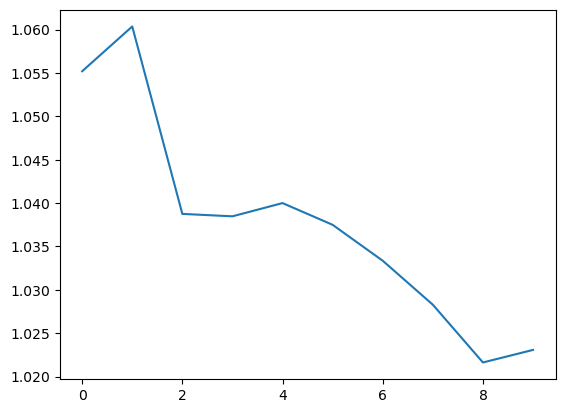

In [71]:
plt.plot(epoch_losses);

In [72]:
src,trg = ds[6]
src,trg = src.unsqueeze(0),trg.unsqueeze(0)

In [73]:
''.join(' '+en_vocab.itos[x] for x in src.squeeze(1).cpu().numpy()[0])

' what types of land cover are associated with the colours below ? <pad> <pad> <pad>'

In [74]:
''.join(' '+fr_vocab.itos[x] for x in model(src).argmax(3).reshape(1,-1).squeeze(0).cpu().numpy())

' a quel types de couverture s liste associez le les les dessous vous dessous ?'